In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import datetime
from glob import glob
from PIL import Image

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Load images

In [2]:
folder_name = './real_data/SHARP_2024-07-02_LBNL/'
mask_name = 'IMO445296'
series = 1
roi_size_px = 332*2
save_folder = './real_data/lines2/'
save_key = 'CD60cb'

folder_date_str = folder_name[-16:-6]
folder_date = datetime.datetime.strptime(folder_date_str, '%Y-%m-%d')

filename_pattern = f"{folder_name}{mask_name}-{folder_date.strftime('%y%m%d')}-{series:04d}-*.png"
image_files = glob(filename_pattern)
num_images = len(image_files)

print(f"Found {num_images} images")

img = []
for i in range(num_images):
    image = Image.open(image_files[i])
    img.append(np.array(image))
    

Found 49 images


## Load metadata

In [3]:
def read_metadata(img):
    """
    Read the metadata included in a SHARP image.
    Adapted from: https://github.com/awojdyla/mip/blob/master/MIP.m
    
    Args:
    input_data (str or np.ndarray): Filename of the image or image data.
    
    Returns:
    dict: Metadata as a dictionary.
    """
    
    # Looking for end delimiter ('99999')
    last_idx = np.where(img[-2, :] == 9)[0][0]
    
    # ASCII conversion, with leading delimiter ('11111') removal
    cell_data = ''.join([chr(c) for c in np.concatenate([img[-1, 6:], img[-2, :last_idx]])]).split(',')
    
    # Converting the resulting list into an array of strings
    str_data = [s.strip() for s in cell_data]
    
    # Populating the metadata dictionary
    metadata = {}
    
    try:
        for data in str_data:
            # Separating field names and values
            tmp = data.split('=')
            tmp_field = tmp[0].strip()
            tmp_value = tmp[1].strip() if len(tmp) > 1 else ''
            
            # Populating fields with numerals or strings
            if re.search(r'[a-z;]', tmp_value, re.IGNORECASE) is None:
                try:
                    metadata[tmp_field] = float(tmp_value)
                except ValueError:
                    metadata[tmp_field] = tmp_value
            else:
                metadata[tmp_field] = tmp_value
    except Exception as err:
        print("Impossible to read metadata.\n ... Make sure you use a recent image and that you have performed no processing on it.")
        if not metadata:
            raise err
    
    return metadata

metadata = []
for i in range(num_images):
    metadata.append(read_metadata(img[i]))



## Crop to sweetspot ROI

In [4]:
# get sweetspot region
meta = metadata[0]
sweet = eval(meta['image_sweetspot'].replace('(', '[').replace(')', ']').replace(';', ','))
b_roi = np.arange(1, roi_size_px + 1) - (roi_size_px + roi_size_px % 2) / 2
x_roi = b_roi + sweet[0]
y_roi = 2048 + b_roi - sweet[1]


## Track drift

In [5]:
from utils import circshift2
def sort_images_and_metadata(images, metadata):
    """
    Sort images and metadata by image number.
    """
    combined = list(zip(images, metadata))
    combined_sorted = sorted(combined, key=lambda x: x[1]['image_number'])
    images_sorted, metadata_sorted = zip(*combined_sorted)
    
    return list(images_sorted), list(metadata_sorted)

img, metadata = sort_images_and_metadata(img, metadata)

# first image is always on-axis illumination
ref_img = img[0]
ref_idx = 0

def find_drift(ref_img, img):
    """
    Find the drift between two images.
    """
    # Find the shift that maximizes the cross-correlation
    shift = np.fft.fftshift(np.fft.ifft2(np.fft.fft2(ref_img)*np.conj(np.fft.fft2(img))))
    x_shift, y_shift = np.unravel_index(np.argmax(shift), shift.shape)
    # Center the index to get shift values
    x_shift = x_shift - shift.shape[0]//2
    y_shift = y_shift - shift.shape[1]//2
    return x_shift, y_shift


for i in range(num_images):
    fx = metadata[i]['ma_arg0']*np.cos(metadata[i]['ma_arg1']*np.pi/180)
    fy = metadata[i]['ma_arg0']*np.sin(metadata[i]['ma_arg1']*np.pi/180)
    if fx == 0 and fy == 0:
        x_shift, y_shift = find_drift(ref_img, img[i])
        print(f"Drift from img{ref_idx+1} to img{i+1}: {x_shift}, {y_shift}")
        for j in range(ref_idx, i):
            img[j] = circshift2(img[j], x_shift, y_shift)
        ref_img = img[i]
        ref_idx = i
    
        


Drift from img1 to img1: 0, 0
Drift from img1 to img6: 0, 0
Drift from img6 to img10: 0, 0
Drift from img10 to img14: 0, 0
Drift from img14 to img18: 0, 0
Drift from img18 to img22: 0, 0
Drift from img22 to img25: 0, 0
Drift from img25 to img41: 0, 0
Drift from img41 to img46: 0, 0
Drift from img46 to img49: 0, 0


## Save images

the APIC mat saving format does not support elliptical pupil

the SHARP image saving format loses precision in sx, sy

Found 40 images


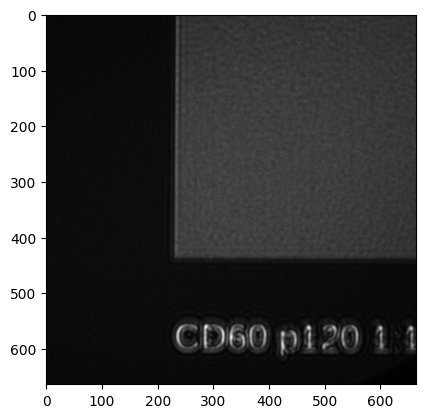

In [11]:
img_roi = []
fxs = []
fys = []

for i in range(num_images):
    fx = metadata[i]['ma_arg0']*np.cos(metadata[i]['ma_arg1']*np.pi/180)
    fy = metadata[i]['ma_arg0']*np.sin(metadata[i]['ma_arg1']*np.pi/180)
    if np.abs(fx) < 1e-10 and np.abs(fy) < 1e-10 and i != 0:
        continue
    else:
        fxs.append(fx)
        fys.append(fy)
        img_roi.append(img[i][np.ix_(y_roi.astype(int), x_roi.astype(int))])

print(f"Found {len(img_roi)} images")

# plot the first image
plt.figure()
plt.imshow(img_roi[0], cmap='gray')
plt.show()

# convert to numpy array
img_roi = np.array(img_roi)
fxs = np.array(fxs)
fys = np.array(fys)
# save to a single file
np.savez(f"{save_folder}{save_key}.npz", imgs=img_roi, sx=fxs, sy=fys)



